In [97]:
#load requiered libraries
library(tidyverse)
library(ggplot2)
library(dplyr)
library(caret)
library(pROC)
library(e1071)
library(rpart)
library(rpart.plot)
library(randomForest)
library(mlbench)
library(xgboost)

options(
  digits = 2,
  scipen = 999
)

<font size = 6> From Step 1: Data Cleaning <font>

https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis

This repository holds the data from a cohort of **pediatric patients with suspected appendicitis admitted with abdominal pain to Children’s Hospital St. Hedwig in Regensburg, Germany, between 2016 and 2021**. <br>

Each patient has (potentially multiple) ultrasound (US) images, aka views, tabular data comprising laboratory, physical examination, scoring results and ultrasonographic findings extracted manually by the experts, and three target variables, namely, diagnosis, management and severity. <br>

This data has 782 rows and 58 columns. There is a combination of binary, categorical, integer and continuous predictor columns. <br>

From column 25 onwards there are multiple columns with na values majorly. These columns are also very specialized and we might not be able to interprete them as good as the other columns. Therefore we will make a selection of the features that are good candidates for our model based on the number of NA values and colinearity.

In [2]:
#Load raw data
df <-  readxl::read_excel("C:\\Users\\minaa\\Desktop\\Statistics\\Spring 2024\\STA 6714\\Term Project\\app_data.xlsx") %>% data.frame()
head(df)
dim(df)

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Management,Severity,Diagnosis_Presumptive,Diagnosis,⋯,Abscess_Location,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,13,16.899999999999999,female,148,37,3,conservative,uncomplicated,appendicitis,appendicitis,⋯,NA,yes,reUB,NA,NA,NA,NA,NA,NA,NA
2,14,31.9,male,147,70,2,conservative,uncomplicated,appendicitis,no appendicitis,⋯,NA,NA,NA,NA,NA,NA,NA,yes,NA,NA
3,14,23.3,female,163,62,4,conservative,uncomplicated,appendicitis,no appendicitis,⋯,NA,NA,NA,NA,NA,NA,NA,yes,yes,NA
4,16,20.6,female,165,56,3,conservative,uncomplicated,appendicitis,no appendicitis,⋯,NA,yes,reUB,NA,NA,NA,NA,NA,yes,NA
5,11,16.899999999999999,female,163,45,3,conservative,uncomplicated,appendicitis,appendicitis,⋯,NA,yes,reUB,NA,NA,NA,NA,NA,yes,NA
6,11,30.7,male,121,45,3,conservative,uncomplicated,appendicitis,no appendicitis,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] 782  58

<font size = 6> From Step 2: Data Partition and Forward Backward model <font>

In [3]:
#Load the clean data
df <- read.csv("clean_data.csv", 
               stringsAsFactor = TRUE, 
               row.names = 1)
df <- df %>% mutate(Diagnosis = as.factor(Diagnosis))
head(df)

,Age,BMI,Sex,Weight,Length_of_Stay,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,⋯,Hemoglobin,RDW,Thrombocyte_Count,CRP,Dysuria,Stool,Peritonitis,Psoas_Sign,Free_Fluids,Diagnosis
,<dbl>,<dbl>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,13,17,female,37,3,no,yes,yes,no,no,⋯,15,12,254,0,no,normal,no,yes,no,1
2,14,32,male,70,2,yes,yes,yes,no,no,⋯,16,13,151,3,yes,normal,no,yes,no,0
3,14,23,female,62,4,no,yes,yes,no,no,⋯,11,12,300,3,no,not_normal,no,yes,no,0
4,16,21,female,56,3,yes,yes,no,no,yes,⋯,14,13,258,0,yes,normal,no,yes,no,0
5,11,17,female,45,3,no,yes,yes,yes,yes,⋯,13,14,311,0,no,not_normal,no,yes,no,1
6,11,31,male,45,3,yes,yes,yes,yes,yes,⋯,12,13,249,63,no,not_normal,no,yes,no,0


<font size = 4> Partition data into train and test: <font>

In [4]:
set.seed(20)
idx <- createDataPartition(df$Diagnosis, p = 0.6, list = FALSE)
df_train <- df[idx, ]
df_test <- df[-idx, ]

<font size = 4> Selected features by the best performing model <font> <br>
<font size = 3> Forward-Backward method model from step 2 for our reference: <font>

In [5]:
#fit the full model
full_model <- glm(Diagnosis ~ .,
                  data = df_train,
                  family = binomial()
                  )

#forward_backward selection
step_both <- MASS::stepAIC(
                          object = full_model,
                          direction = "both",
                          trace = 0
                          )

<font size = 4> Prediction of train set and confusion matrix for Forward-Backward model: <font>

In [6]:
pred_prob_step <-   predict(object = step_both, 
                            newdata = df_test,
                            type = "response") %>% as.vector()

threshold <- 0.5
pred_class_step <- if_else(pred_prob_step > threshold, 1, 0) %>% as.factor()

#store accuracy for comparison at the end
cm_step <- confusionMatrix(pred_class_step, reference = df_test$Diagnosis, positive = "1")$overall["Accuracy"][[1]] %>% round(2)

confusionMatrix(pred_class_step, reference = df_test$Diagnosis, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 69 37
         1 25 89
                                        
               Accuracy : 0.718         
                 95% CI : (0.654, 0.777)
    No Information Rate : 0.573         
    P-Value [Acc > NIR] : 0.0000058     
                                        
                  Kappa : 0.433         
                                        
 Mcnemar's Test P-Value : 0.162         
                                        
            Sensitivity : 0.706         
            Specificity : 0.734         
         Pos Pred Value : 0.781         
         Neg Pred Value : 0.651         
             Prevalence : 0.573         
         Detection Rate : 0.405         
   Detection Prevalence : 0.518         
      Balanced Accuracy : 0.720         
                                        
       'Positive' Class : 1             
                                        

In [7]:
selected_features_step2 <-  names(coefficients(step_both))[-1] 
selected_features_step2  <- gsub("yes$", "", selected_features_step2)
selected_features_step2

[1] "Age"                   "BMI"                   "Length_of_Stay"       
 [4] "Migratory_Pain"        "Coughing_Pain"         "Body_Temperature"     
 [7] "WBC_Count"             "Neutrophil_Percentage" "RDW"                  
[10] "Thrombocyte_Count"     "Stoolnot_normal"       "Peritonitis"          
[13] "Psoas_Sign"

<font size = 6> Naive Bayes Model:<font>

For Naive Bayes model we need to pay attention to the numeircal columns. Since we have 12 numerical columns, we need to check their distributions and whether they can be transformed to normal or they can be transformed to categorical by binning method.

In [8]:
df_train %>% select(where(is.numeric)) %>% head()

,Age,BMI,Weight,Length_of_Stay,Body_Temperature,WBC_Count,Neutrophil_Percentage,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,CRP
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
3,14.1,23,62,4,37,13.2,75,4.0,11,12,300,3
4,16.4,21,56,3,36,11.4,63,4.6,14,13,258,0
5,11.1,17,45,3,37,8.1,44,4.4,13,14,311,0
7,9.0,19,38,3,37,10.0,69,4.8,13,13,337,9
8,7.9,16,27,3,37,20.9,76,4.6,13,12,350,20
9,14.3,15,46,3,37,5.8,47,4.8,13,13,220,0


<font size = 4> **Check the normality of the numerical predictors:** <font>

<font size = 4> Visualizing the numerical columns distributions and their transforms: <font> <br>
<font size = 3> Original, squared root, log, inverse <font>

Experiment with square root, logarithmic, and inverse transformations on each of the numerical columns to identify the transformation that yields a distribution closest to normal.

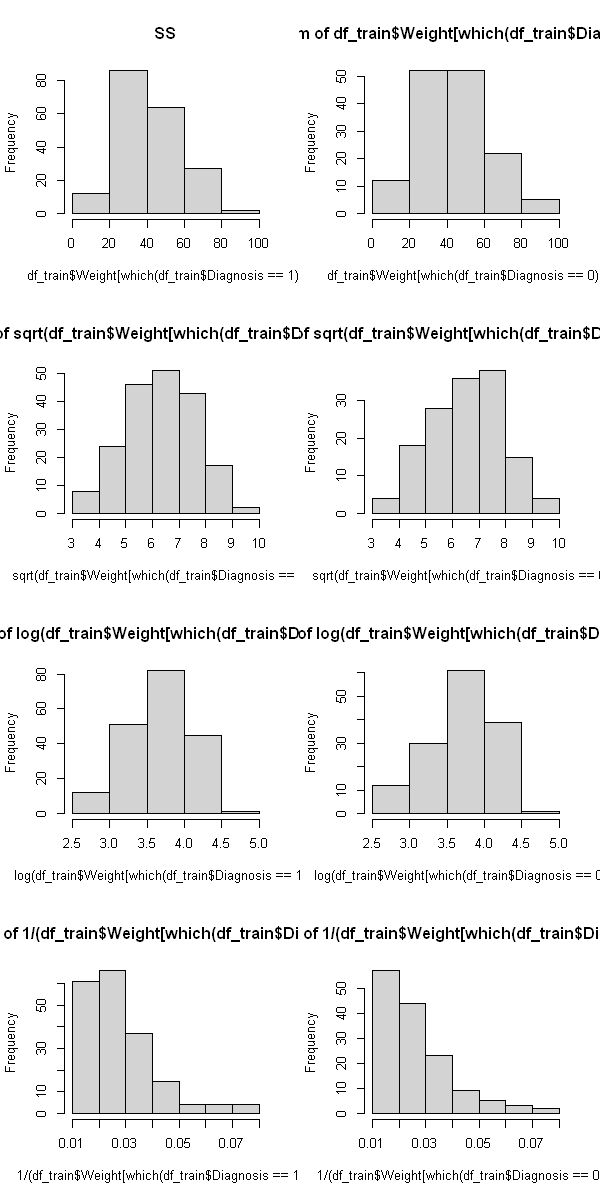

In [9]:
#Experimenting with transformations of Weight column
options(repr.plot.width = 5, repr.plot.height = 10)
par(mfrow = c(4, 2))

#original skewed data
hist(   df_train$Weight[which(df_train$Diagnosis == 1)], breaks = 5, main = "SS")
hist(   df_train$Weight[which(df_train$Diagnosis == 0)], breaks = 5)

#square root transformation 
hist(   sqrt(df_train$Weight[which(df_train$Diagnosis == 1)]), breaks = 5)
hist(   sqrt(df_train$Weight[which(df_train$Diagnosis == 0)]), breaks = 5)

#log transformation
hist(   log(df_train$Weight[which(df_train$Diagnosis == 1)]), breaks = 5)
hist(   log(df_train$Weight[which(df_train$Diagnosis == 0)]), breaks = 5)

#inverse transformation
hist(   1/(df_train$Weight[which(df_train$Diagnosis == 1)]), breaks = 5)
hist(   1/(df_train$Weight[which(df_train$Diagnosis == 0)]), breaks = 5)

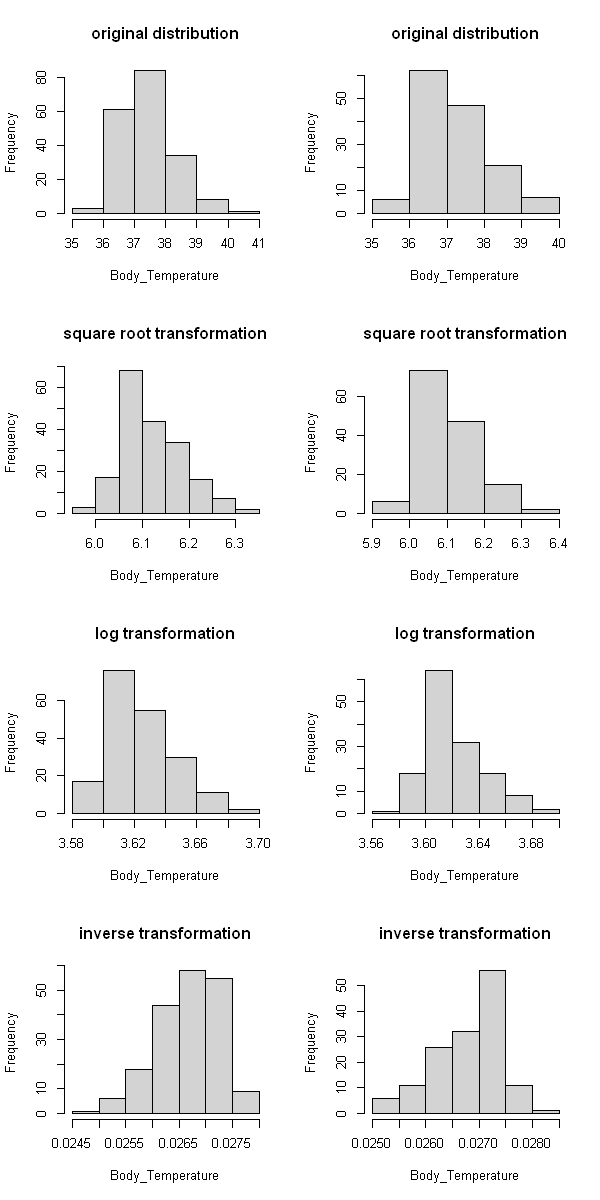

In [10]:
#Experimenting with transformations of Body_Temperature column

options(repr.plot.width = 5, repr.plot.height = 10)
par(mfrow = c(4, 2))

#original skewed data
hist(   df_train$Body_Temperature[which(df_train$Diagnosis == 1)], breaks = 5, main = "original distribution", xlab="Body_Temperature")
hist(   df_train$Body_Temperature[which(df_train$Diagnosis == 0)], breaks = 5, , main = "original distribution", xlab="Body_Temperature")

#square root transformation 
hist(   sqrt(df_train$Body_Temperature[which(df_train$Diagnosis == 1)]), breaks = 5, main = "square root transformation", xlab="Body_Temperature")
hist(   sqrt(df_train$Body_Temperature[which(df_train$Diagnosis == 0)]), breaks = 5, main = "square root transformation", xlab="Body_Temperature")

#log transformation
hist(   log(df_train$Body_Temperature[which(df_train$Diagnosis == 1)]), breaks = 5, main = "log transformation", xlab="Body_Temperature")
hist(   log(df_train$Body_Temperature[which(df_train$Diagnosis == 0)]), breaks = 5, main = "log transformation", xlab="Body_Temperature")

#inverse transformation
hist(   1/(df_train$Body_Temperature[which(df_train$Diagnosis == 1)]), breaks = 5, main = "inverse transformation", xlab="Body_Temperature")
hist(   1/(df_train$Body_Temperature[which(df_train$Diagnosis == 0)]), breaks = 5, main = "inverse transformation", xlab="Body_Temperature")

After visualizing the effect of transformation on the numerical columns, transformations below would be the best options for each column: <br>
**square root transformation:** "Weight" <br>
**inverse transformation:** "BMI" <br>
**log:** "Body_Temperature", "Thrombocyte_Count", "WBC_Count" 

<font size = 4> Visualizing the transformations for the presentation: <font>

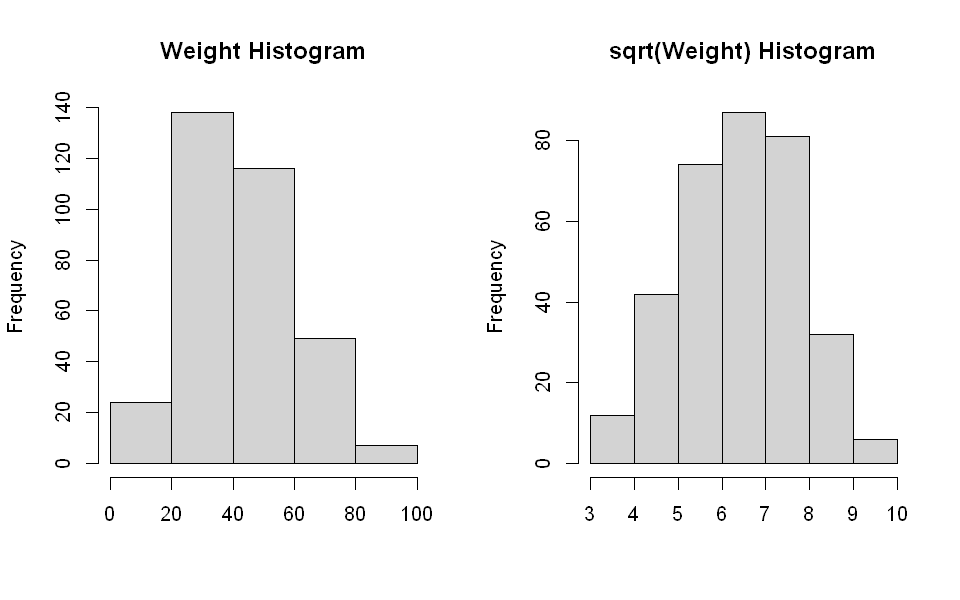

In [11]:
#sqrt Transformation
options(repr.plot.width = 8, repr.plot.height = 5)
par(mfrow = c(1, 2))
hist(df_train$Weight, breaks = 5, main = "Weight Histogram", xlab = "")
hist(sqrt(df_train$Weight), breaks = 5,  main = "sqrt(Weight) Histogram", xlab = "")

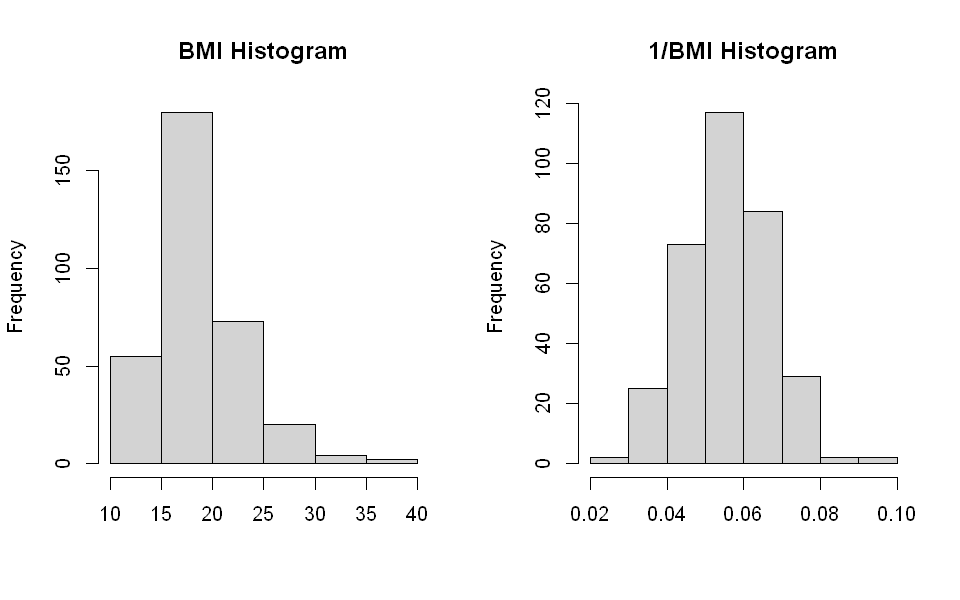

In [12]:
#inverse Transformation
options(repr.plot.width = 8, repr.plot.height = 5)
par(mfrow = c(1, 2))
hist(df_train$BMI, breaks = 5, main = "BMI Histogram", xlab = "")
hist(1/(df_train$BMI), breaks = 5,  main = "1/BMI Histogram", xlab = "")

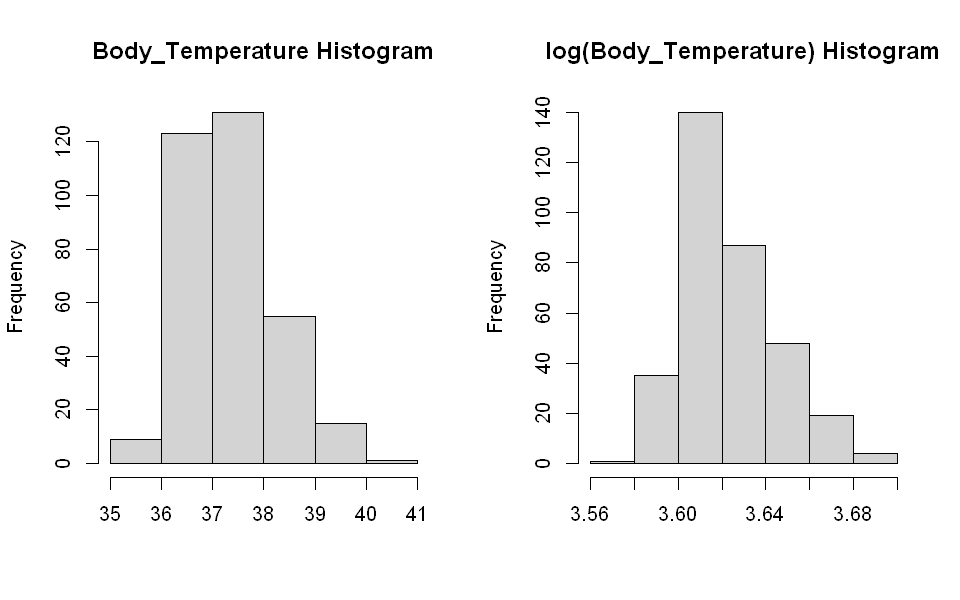

In [13]:
#log Transformation
options(repr.plot.width = 8, repr.plot.height = 5)
par(mfrow = c(1, 2))
hist(df_train$Body_Temperature, breaks = 5, main = "Body_Temperature Histogram", xlab = "")
hist(log(df_train$Body_Temperature), breaks = 5,  main = "log(Body_Temperature) Histogram", xlab = "")

After deciding on each numerical column transformation, we need to transform both train and test set.

In [14]:
#transform train set
df_train_transformed <-  df_train %>% 
                                    mutate(Weight = sqrt(Weight),
                                           BMI = (1/BMI),
                                           Body_Temperature = log(Body_Temperature),
                                           Thrombocyte_Count = log(Thrombocyte_Count),
                                           WBC_Count = log(WBC_Count))

#transform test set
df_test_transformed <-  df_test %>% 
                                    mutate(Weight = sqrt(Weight),
                                           BMI = (1/BMI),
                                           Body_Temperature = log(Body_Temperature),
                                           Thrombocyte_Count = log(Thrombocyte_Count),
                                           WBC_Count = log(WBC_Count))

<font size = 4> Shapiro-Wilk Normality Test: <font>

Transformation did not help the normality of rest of the numerical columns. Therefore we will run the Shapiro normality test on them to check them out.

In [15]:
selected_cols <- c("Age", "RBC_Count", "Length_of_Stay", "Hemoglobin", "Neutrophil_Percentage", "RDW", "CRP", "Diagnosis")
a <- df_train[, selected_cols]

#number of numerical predictors
n <- length(a) - 1

#print out the Shapiro normality test for the numerical columns based on their classes
for (i in 1:n){
    print(names(a)[i])
    print(shapiro.test(a[,i][a$Diagnosis == 1]))
    print(shapiro.test(a[,i][a$Diagnosis == 0]))
}


[1] "Age"

	Shapiro-Wilk normality test

data:  a[, i][a$Diagnosis == 1]
W = 1, p-value = 0.005


	Shapiro-Wilk normality test

data:  a[, i][a$Diagnosis == 0]
W = 1, p-value = 0.03

[1] "RBC_Count"

	Shapiro-Wilk normality test

data:  a[, i][a$Diagnosis == 1]
W = 1, p-value = 0.3


	Shapiro-Wilk normality test

data:  a[, i][a$Diagnosis == 0]
W = 1, p-value = 0.02

[1] "Length_of_Stay"

	Shapiro-Wilk normality test

data:  a[, i][a$Diagnosis == 1]
W = 0.8, p-value = 0.000000000000009


	Shapiro-Wilk normality test

data:  a[, i][a$Diagnosis == 0]
W = 0.6, p-value <0.0000000000000002

[1] "Hemoglobin"

	Shapiro-Wilk normality test

data:  a[, i][a$Diagnosis == 1]
W = 1, p-value = 0.2


	Shapiro-Wilk normality test

data:  a[, i][a$Diagnosis == 0]
W = 1, p-value = 0.5

[1] "Neutrophil_Percentage"

	Shapiro-Wilk normality test

data:  a[, i][a$Diagnosis == 1]
W = 0.9, p-value = 0.0000000004


	Shapiro-Wilk normality test

data:  a[, i][a$Diagnosis == 0]
W = 1, p-value = 0.005

[1] "RDW"

As we expected most of them do not have a normal distribution in at least one of the classes.

<font size = 4> Bin the remaining numerical columns in train and test set: <font>

Predictors above have the majority of their values around one point, therefore we will bin each column into 4 bins so they will fall into 4 categories in each column.

In [16]:
label <- c("1", "2", "3", "4")

#Binning train set
df_train_transformed  <-     df_train_transformed%>% 
                                        mutate(Age = cut(Age, b = 4, label = label),
                                               RBC_Count = cut(RBC_Count, b = 4, label = label),
                                               Hemoglobin = cut(Hemoglobin, b = 4, label = label),
                                               Length_of_Stay = cut(Length_of_Stay, b = 4, label = label),
                                               Neutrophil_Percentage = cut(Neutrophil_Percentage, b = 4, label = label),
                                               RDW = cut(RDW, b = 4, label = label),
                                               CRP = cut(CRP, b = 4, label = label)
                                               )

#Binning test set
df_test_transformed  <-     df_test_transformed%>% 
                                        mutate(Age = cut(Age, b = 4, label = label),
                                               RBC_Count = cut(RBC_Count, b = 4, label = label),
                                               Hemoglobin = cut(Hemoglobin, b = 4, label = label),
                                               Length_of_Stay = cut(Length_of_Stay, b = 4, label = label),
                                               Neutrophil_Percentage = cut(Neutrophil_Percentage, b = 4, label = label),
                                               RDW = cut(RDW, b = 4, label = label),
                                               CRP = cut(CRP, b = 4, label = label)
                                               )

<font size = 4> Visualizing the binning for the presentation: <font>

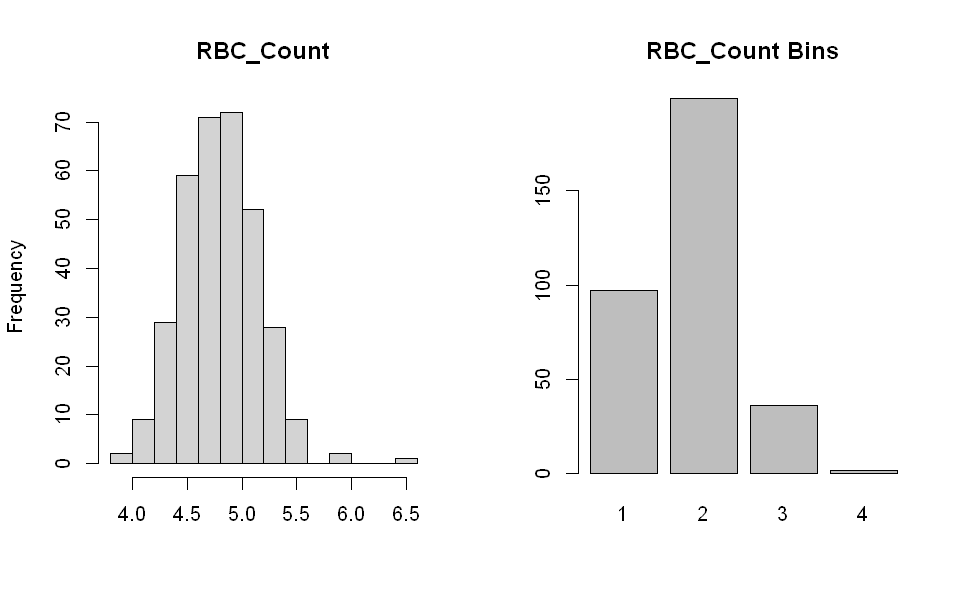

In [17]:
options(repr.plot.width = 8, repr.plot.height = 5)
par(mfrow = c(1, 2))
hist(df_train$RBC_Count, main = "RBC_Count", xlab = "")
barplot(table(df_train_transformed$RBC_Count), main = "RBC_Count Bins")

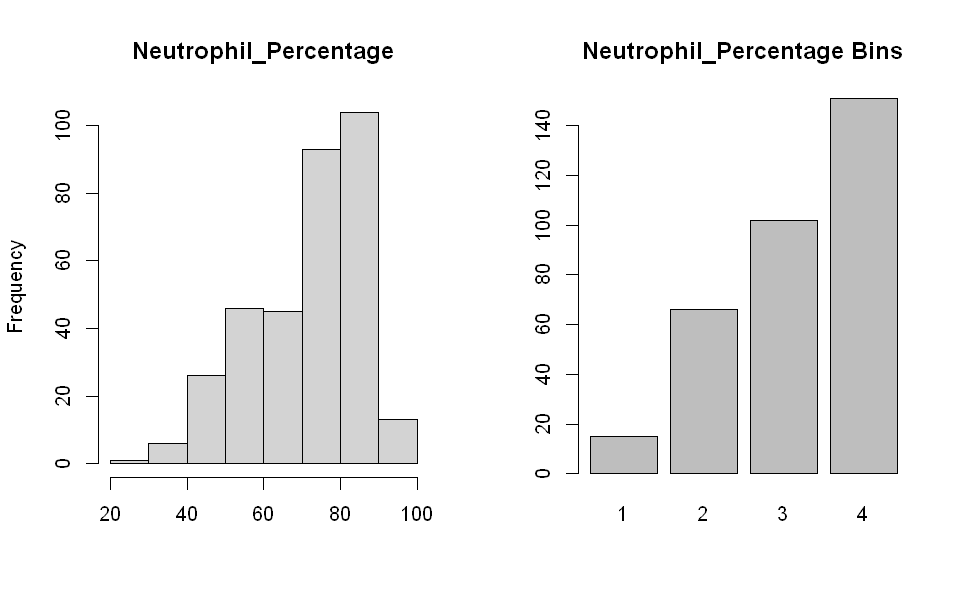

In [18]:
options(repr.plot.width = 8, repr.plot.height = 5)
par(mfrow = c(1, 2))
hist(df_train$Neutrophil_Percentage, main = "Neutrophil_Percentage", xlab = "", breaks = 6)
barplot(table(df_train_transformed$Neutrophil_Percentage), main = "Neutrophil_Percentage Bins")

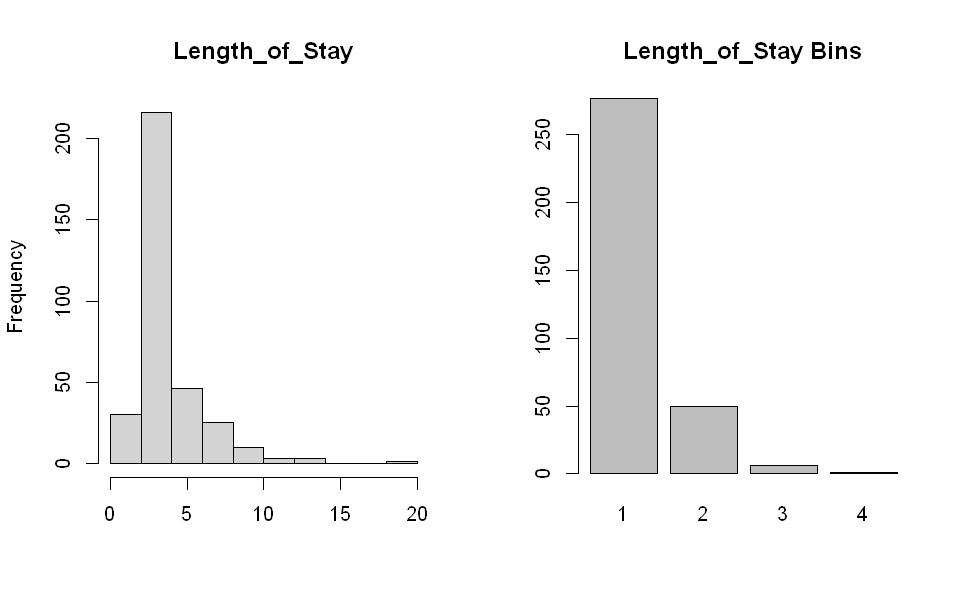

In [19]:
options(repr.plot.width = 8, repr.plot.height = 5)
par(mfrow = c(1, 2))
hist(df_train$Length_of_Stay, main = "Length_of_Stay", xlab = "")
barplot(table(df_train_transformed$Length_of_Stay), main = "Length_of_Stay Bins")

<font size = 4> Fit Naive Bayes Model: <font>

In [20]:
#fit the naive Bayes model on the train set
naive_model <-    naiveBayes(Diagnosis ~ .,
                             data = df_train_transformed)
naive_model


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
   0    1 
0.43 0.57 

Conditional probabilities:
   Age
Y       1     2     3     4
  0 0.042 0.210 0.448 0.301
  1 0.047 0.178 0.497 0.277

   BMI
Y    [,1]  [,2]
  0 0.054 0.012
  1 0.057 0.010

   Sex
Y   female male
  0    0.5  0.5
  1    0.4  0.6

   Weight
Y   [,1] [,2]
  0  6.6  1.4
  1  6.4  1.3

   Length_of_Stay
Y        1      2      3      4
  0 0.9860 0.0140 0.0000 0.0000
  1 0.7120 0.2513 0.0314 0.0052

   Migratory_Pain
Y     no  yes
  0 0.78 0.22
  1 0.68 0.32

   Lower_Right_Abd_Pain
Y      no   yes
  0 0.042 0.958
  1 0.037 0.963

   Contralateral_Rebound_Tenderness
Y     no  yes
  0 0.72 0.28
  1 0.55 0.45

   Coughing_Pain
Y     no  yes
  0 0.80 0.20
  1 0.68 0.32

   Nausea
Y     no  yes
  0 0.53 0.47
  1 0.34 0.66

   Loss_of_Appetite
Y     no  yes
  0 0.55 0.45
  1 0.43 0.57

   Body_Temperature
Y   [,1]  [,2]
  0  3.6 0.023
  1  

<font size = 4> Prediction of train set and confusion matrix for Naive Bayes: <font>

In [21]:
pred_prob_naive_tr <-   predict(object = naive_model,
                              newdata = df_train_transformed,
                              type = "raw")[, 2]

pred_class_naive_tr <- if_else(pred_prob_naive_tr > threshold, 1, 0) %>% as.factor()


confusionMatrix(pred_class_naive_tr, reference = df_train_transformed$Diagnosis, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 101  52
         1  42 139
                                        
               Accuracy : 0.719         
                 95% CI : (0.667, 0.766)
    No Information Rate : 0.572         
    P-Value [Acc > NIR] : 0.000000021   
                                        
                  Kappa : 0.43          
                                        
 Mcnemar's Test P-Value : 0.353         
                                        
            Sensitivity : 0.728         
            Specificity : 0.706         
         Pos Pred Value : 0.768         
         Neg Pred Value : 0.660         
             Prevalence : 0.572         
         Detection Rate : 0.416         
   Detection Prevalence : 0.542         
      Balanced Accuracy : 0.717         
                                        
       'Positive' Class : 1             
                                        

<font size = 4> Prediction of test set and confusion matrix for Naive Bayes: <font>

In [22]:
pred_prob_naive <-   predict(object = naive_model,
                              newdata = df_test_transformed,
                              type = "raw")[, 2]

pred_class_naive <- if_else(pred_prob_naive > 0.5, 1, 0) %>% as.factor()

#store accuracy for comparison at the end
cm_naive <- confusionMatrix(pred_class_naive, reference = df_test_transformed$Diagnosis, positive = "1")$overall["Accuracy"][[1]] %>% round(2)

confusionMatrix(pred_class_naive, reference = df_test_transformed$Diagnosis, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 75 51
         1 19 75
                                        
               Accuracy : 0.682         
                 95% CI : (0.616, 0.743)
    No Information Rate : 0.573         
    P-Value [Acc > NIR] : 0.000584      
                                        
                  Kappa : 0.377         
                                        
 Mcnemar's Test P-Value : 0.000211      
                                        
            Sensitivity : 0.595         
            Specificity : 0.798         
         Pos Pred Value : 0.798         
         Neg Pred Value : 0.595         
             Prevalence : 0.573         
         Detection Rate : 0.341         
   Detection Prevalence : 0.427         
      Balanced Accuracy : 0.697         
                                        
       'Positive' Class : 1             
                                        

The accuracy of the prediction on the train set is slightly higher. 

<font size = 6> Decision Tree Model: <font>

We will set the maximum depth to 4 to avoid overfitting. Also will include all the features, because decision tree model does the feature selection by itself.

In [23]:
#fit the decision tree model on train set
tree_model <- rpart(Diagnosis ~ .,
                    data = df_train,
                    method = "class",
                    maxdepth = 4)
summary(tree_model)

Call:
rpart(formula = Diagnosis ~ ., data = df_train, method = "class", 
    maxdepth = 4)
  n= 334 

     CP nsplit rel error xerror  xstd
1 0.336      0      1.00   1.00 0.063
2 0.056      1      0.66   0.66 0.058
3 0.042      2      0.61   0.69 0.058
4 0.010      5      0.48   0.65 0.057

Variable importance
       Length_of_Stay Neutrophil_Percentage             WBC_Count 
                   29                    16                    13 
          Peritonitis                   CRP      Body_Temperature 
                   11                    10                     8 
    Thrombocyte_Count                   Age                Weight 
                    5                     3                     2 
            RBC_Count          Neutrophilia                   BMI 
                    1                     1                     1 

Node number 1: 334 observations,    complexity param=0.34
  predicted class=1  expected loss=0.43  P(node) =1
    class counts:   143   191
   probabi

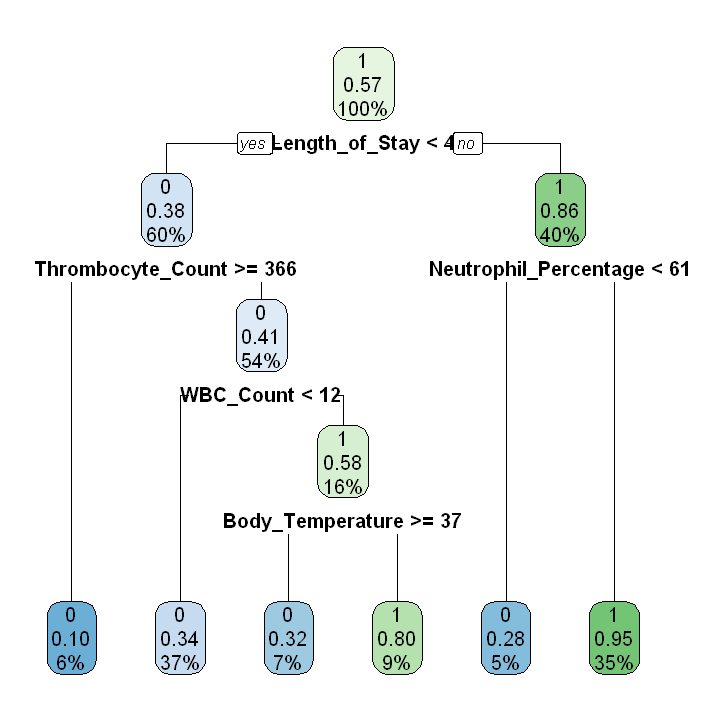

In [24]:
options(repr.plot.width = 6, repr.plot.height = 6)
rpart.plot(tree_model)

While the tree classifies some of the data very well, it does perform poorly on some other observations. For example we see that 35% of the data fell into a bucket with 0.95 accurate label. However, 37% of the data ended up in a bucket which only has a 0.66 accurate label.


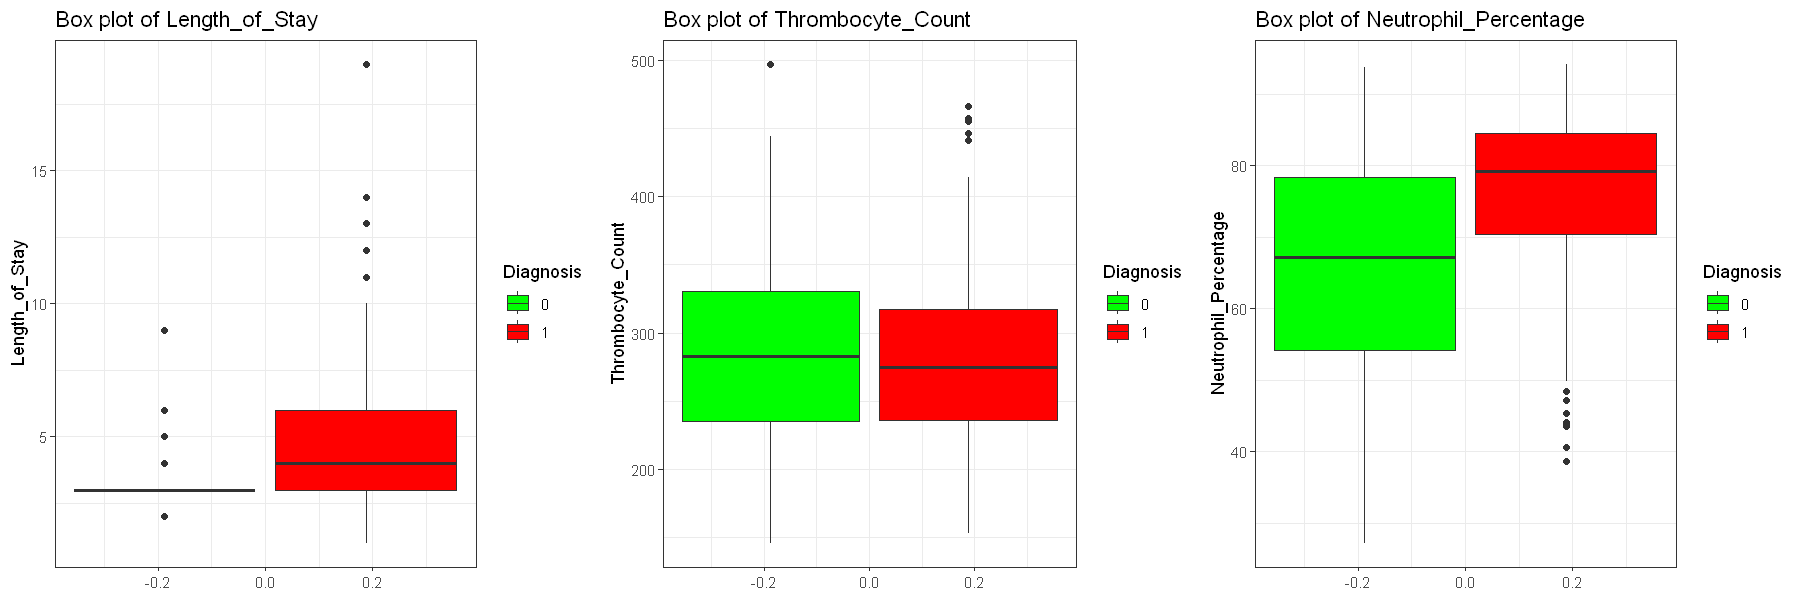

In [25]:
options(repr.plot.width = 15, repr.plot.height = 5)

#Check Length_of_Stay distribution in regards to our target classes
plot1 <-   ggplot(df_train) +
                aes(y = Length_of_Stay, fill = Diagnosis)+
                geom_boxplot() +
                theme_bw() +
                scale_fill_manual(values = c("green", "red")) +
                labs(title = "Box plot of Length_of_Stay")

#Check Thrombocyte_Count distribution in regards to our target classes
plot2 <-    ggplot(df_train) +
                aes(y = Thrombocyte_Count, fill = Diagnosis)+
                geom_boxplot() +
                theme_bw() +
                scale_fill_manual(values = c("green", "red")) +
                labs(title = "Box plot of Thrombocyte_Count")

#Check Neutrophil_Percentage distribution in regards to our target classes
plot3 <-     ggplot(df_train) +
                aes(y = Neutrophil_Percentage, fill = Diagnosis)+
                geom_boxplot() +
                theme_bw() +
                scale_fill_manual(values = c("green", "red")) +
                labs(title = "Box plot of Neutrophil_Percentage")

gridExtra::grid.arrange(plot1, plot2, plot3, ncol = 3)

**Length_of_Stay** and **Neutrophil_Percentage** which are the first choices for splitting the tree, each have two different distributions for Diagnosis = 1 and Diagnosis = 0. We already knew that and saw that the forward-backward method selected these predictors too. <br>

However, **Thrombocyte_Count** have not been picked as a good predictor so far and also we see in the plot that label 0 and 1 s do not have two distinct distributions. <br>
subsequently, we will see that the Decision Tree's performance is lower than other models, potentialy attributes to this particular split.

<font size = 4> Prediction of train set and confusion matrix for Decision Tree: <font>

In [26]:
pred_prob_tree_tr <-     predict(object = tree_model,
                              newdata = df_train,
                              type = "prob")[, 2] %>% as.vector()

pred_class_tree_tr <- if_else(pred_prob_tree_tr > threshold, 1, 0) %>% as.factor()

confusionMatrix(pred_class_tree_tr, reference = df_train$Diagnosis, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 131  57
         1  12 134
                                              
               Accuracy : 0.793               
                 95% CI : (0.746, 0.836)      
    No Information Rate : 0.572               
    P-Value [Acc > NIR] : < 0.0000000000000002
                                              
                  Kappa : 0.594               
                                              
 Mcnemar's Test P-Value : 0.000000118         
                                              
            Sensitivity : 0.702               
            Specificity : 0.916               
         Pos Pred Value : 0.918               
         Neg Pred Value : 0.697               
             Prevalence : 0.572               
         Detection Rate : 0.401               
   Detection Prevalence : 0.437               
      Balanced Accuracy : 0.809               
                                            

<font size = 4> Prediction of test set and confusion matrix for Decision Tree: <font>

In [27]:
pred_prob_tree <-     predict(object = tree_model,
                              newdata = df_test,
                              type = "prob")[, 2] %>% as.vector()

pred_class_tree <- if_else(pred_prob_tree > threshold, 1, 0) %>% as.factor()

#store accuracy for comparison at the end
cm_tree <- confusionMatrix(pred_class_tree, reference = df_test$Diagnosis, positive = "1")$overall["Accuracy"][[1]] %>% round(2)

confusionMatrix(pred_class_tree, reference = df_test$Diagnosis, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 77 53
         1 17 73
                                        
               Accuracy : 0.682         
                 95% CI : (0.616, 0.743)
    No Information Rate : 0.573         
    P-Value [Acc > NIR] : 0.000584      
                                        
                  Kappa : 0.38          
                                        
 Mcnemar's Test P-Value : 0.0000287     
                                        
            Sensitivity : 0.579         
            Specificity : 0.819         
         Pos Pred Value : 0.811         
         Neg Pred Value : 0.592         
             Prevalence : 0.573         
         Detection Rate : 0.332         
   Detection Prevalence : 0.409         
      Balanced Accuracy : 0.699         
                                        
       'Positive' Class : 1             
                                        

<font size = 6> Random Forest: <font>

In [28]:
#fit the random forest model on train set
set.seed(22)

rf_model <- randomForest(Diagnosis ~ .,
                         data = df_train,
                         ntree = 100,
                         mtry = 5,
                         maxnodes = 5,
                         importance = TRUE)


<font size = 4 > Variable Importance: <font>

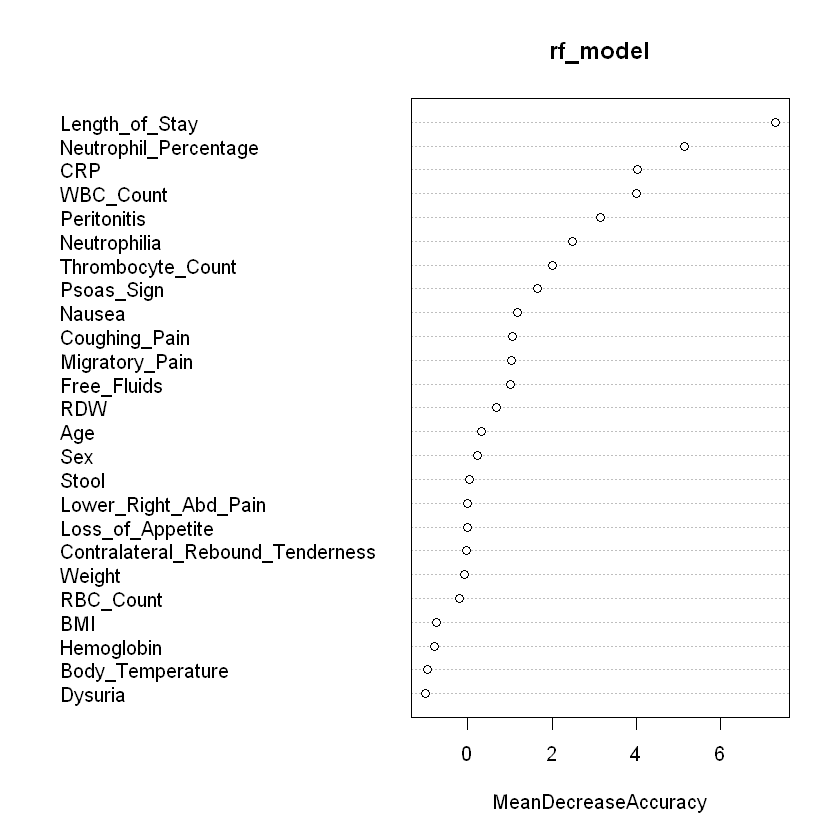

In [29]:
options(repr.plot.width = 7, repr.plot.height = 7)

varImpPlot(rf_model, type = 1)

<font size = 4> Prediction of train set and confusion matrix for Random Forest: <font>

In [30]:
pred_prob_rf_tr <-   predict(object = rf_model,
                           newdata = df_train,
                           type = "prob")[, 2] %>% as.vector()

pred_class_rf_tr <- if_else(pred_prob_rf_tr > threshold, 1, 0) %>% as.factor()

confusionMatrix(pred_class_rf_tr, reference = df_train$Diagnosis, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  98  33
         1  45 158
                                            
               Accuracy : 0.766             
                 95% CI : (0.717, 0.811)    
    No Information Rate : 0.572             
    P-Value [Acc > NIR] : 0.0000000000000799
                                            
                  Kappa : 0.518             
                                            
 Mcnemar's Test P-Value : 0.213             
                                            
            Sensitivity : 0.827             
            Specificity : 0.685             
         Pos Pred Value : 0.778             
         Neg Pred Value : 0.748             
             Prevalence : 0.572             
         Detection Rate : 0.473             
   Detection Prevalence : 0.608             
      Balanced Accuracy : 0.756             
                                            
       'Positive' Class : 1        

<font size = 4> Prediction of test set and confusion matrix for Random Forest: <font>

In [31]:
pred_prob_rf <-   predict(object = rf_model,
                           newdata = df_test,
                           type = "prob")[, 2] %>% as.vector()

pred_class_rf <- if_else(pred_prob_rf > threshold, 1, 0) %>% as.factor()

#store accuracy for comparison at the end
cm_rf <- confusionMatrix(pred_class_rf, reference = df_test$Diagnosis, positive = "1")$overall["Accuracy"][[1]] %>% round(2)

confusionMatrix(pred_class_rf, reference = df_test$Diagnosis, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 63 29
         1 31 97
                                        
               Accuracy : 0.727         
                 95% CI : (0.663, 0.785)
    No Information Rate : 0.573         
    P-Value [Acc > NIR] : 0.00000148    
                                        
                  Kappa : 0.441         
                                        
 Mcnemar's Test P-Value : 0.897         
                                        
            Sensitivity : 0.770         
            Specificity : 0.670         
         Pos Pred Value : 0.758         
         Neg Pred Value : 0.685         
             Prevalence : 0.573         
         Detection Rate : 0.441         
   Detection Prevalence : 0.582         
      Balanced Accuracy : 0.720         
                                        
       'Positive' Class : 1             
                                        

<font size = 4> **Discussion about Random Forest model:** <font>

**Accuracy:**<br>
As we see the random forest performance is good on both predicting the train and test set. <br>


**Variable Importance:**<br>
Also, based on the variable importance plot, **Length_of_Stay** decreases the impurity much better than the other predictors, and after that **CRP**, **Peritonitis**, **WBC_Count** and **Neutrophil_Percentage** are the best predictors in decreasing the impurity of the splits. <br>

Comparing variable importance with the features selected by forward-backward method in step 2, we would see that there are a lot of similarities and both models have picked out the features which are most informative about the target variable.

<font size = 6> Boosting: <font>

We expect to see a better performance from boosting models because they optimize the error by sequentially training weaklearners.

In [32]:
#fit the xgboost model on the train set
set.seed(22)

xgb_model <-   train(Diagnosis ~., 
                       data = df_train,
                       method = "xgbTree",
                       verbosity = 0)


<font size = 4> Prediction of train set and confusion matrix for Boosting: <font>

In [33]:
pred_prob_xgb_tr <-   predict(xgb_model,
                           newdata = df_train,
                           type = "prob")[[2]]

pred_class_xgb_tr <- if_else(pred_prob_xgb_tr > threshold, 1, 0) %>% as.factor()

confusionMatrix(pred_class_xgb_tr, reference = df_train$Diagnosis, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 114  29
         1  29 162
                                             
               Accuracy : 0.826              
                 95% CI : (0.781, 0.865)     
    No Information Rate : 0.572              
    P-Value [Acc > NIR] : <0.0000000000000002
                                             
                  Kappa : 0.645              
                                             
 Mcnemar's Test P-Value : 1                  
                                             
            Sensitivity : 0.848              
            Specificity : 0.797              
         Pos Pred Value : 0.848              
         Neg Pred Value : 0.797              
             Prevalence : 0.572              
         Detection Rate : 0.485              
   Detection Prevalence : 0.572              
      Balanced Accuracy : 0.823              
                                             
       'Positive

<font size = 4> Prediction of test set and confusion matrix for Boosting: <font>

In [34]:
pred_prob_xgb <-   predict(xgb_model,
                           newdata = df_test,
                           type = "prob")[[2]]

pred_class_xgb <- if_else(pred_prob_xgb > threshold, 1, 0) %>% as.factor()

#store accuracy for comparison at the end
cm_xgb <- confusionMatrix(pred_class_xgb, reference = df_test$Diagnosis, positive = "1")$overall["Accuracy"][[1]] %>% round(2)

confusionMatrix(pred_class_xgb, reference = df_test$Diagnosis, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  61  25
         1  33 101
                                        
               Accuracy : 0.736         
                 95% CI : (0.673, 0.793)
    No Information Rate : 0.573         
    P-Value [Acc > NIR] : 0.000000347   
                                        
                  Kappa : 0.455         
                                        
 Mcnemar's Test P-Value : 0.358         
                                        
            Sensitivity : 0.802         
            Specificity : 0.649         
         Pos Pred Value : 0.754         
         Neg Pred Value : 0.709         
             Prevalence : 0.573         
         Detection Rate : 0.459         
   Detection Prevalence : 0.609         
      Balanced Accuracy : 0.725         
                                        
       'Positive' Class : 1             
                                        

<font size = 4> **Discussion about Boosting model:** <font>

**Accuracy:** <br>
The accuracy of the train set is higher. However still the accuracy of the test set is the highest among all the models. We need to look at the ROC curve to analyze it better.

<font size=6> Final Comparison of the models predicting the test set <font>

In [35]:
#Decision Tree, Random Forest, XGBoost
final_comparison <-    data.frame(model = c("Naive Bayes", "Decision Tree", "Random Forest", "xgboost"),
                                  accuracy = c(cm_naive, cm_tree, cm_rf, cm_xgb)) %>% arrange(desc(accuracy))
final_comparison

model,accuracy
<chr>,<dbl>
xgboost,0.74
Random Forest,0.73
Naive Bayes,0.68
Decision Tree,0.68


Based on the results, boosting is the best-performing model in accuracy. <br>
Given our prioritization of sensitivity over specificity, important for identifying positive cases of Appendicitis, we used a threshold of 0.5 for classifying predicted probabilities.<br>
Random Forest is the 2nd performing model. <br>
Considering the comparable performance of Naive Bayes and Decision tree models, all the data transformation and preparation before fitting the Naive Bayes model might not be worth it, compared to the minimal data preparation for fitting decision tree model.

<font size = 6> ROC <font>

**Comparison of ROC curves for different models on train set**

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



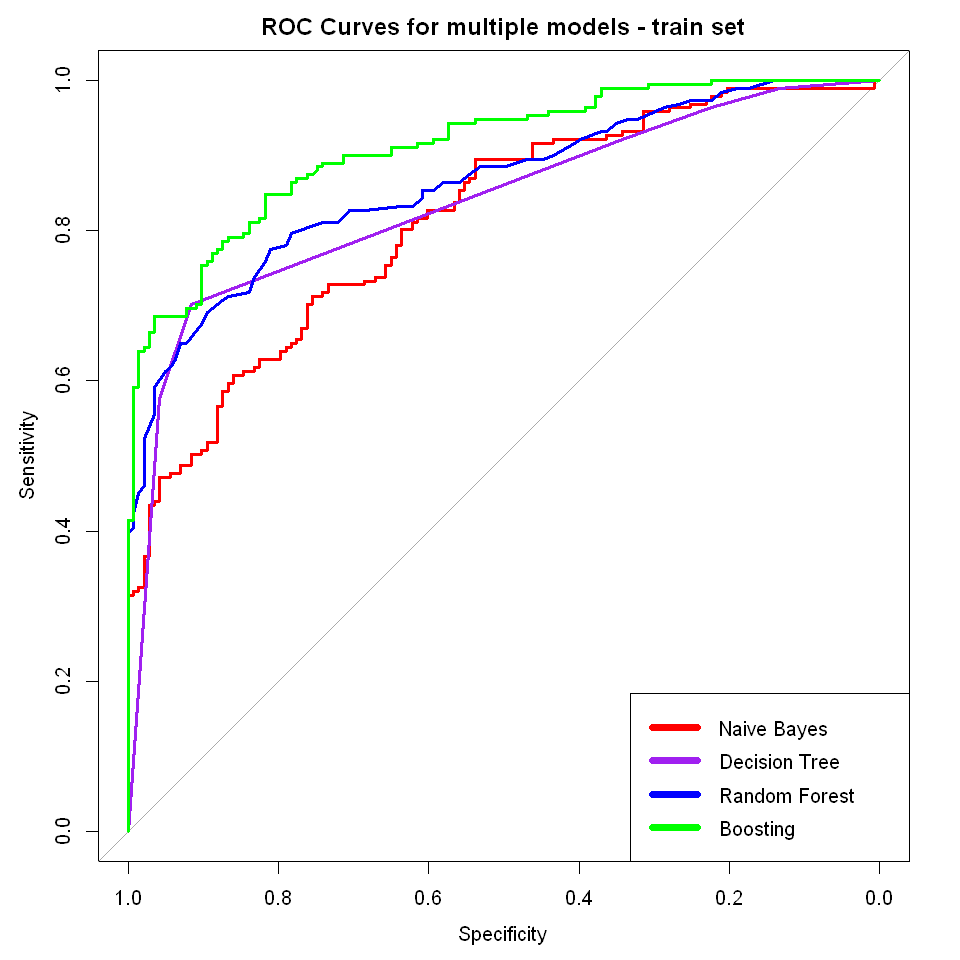

In [36]:
options(repr.plot.width = 8, repr.plot.height = 8)

plot(roc(df_train$Diagnosis, pred_prob_naive_tr), main = "ROC Curves for multiple models - train set", col = "red", lwd = 3)
plot(roc(df_train$Diagnosis, pred_prob_tree_tr), col = "purple", lwd = 3, add=TRUE)
plot(roc(df_train$Diagnosis, pred_prob_rf_tr), col = "blue", lwd = 3, add=TRUE)
plot(roc(df_train$Diagnosis, pred_prob_xgb_tr), col = "green", lwd = 3, add=TRUE)

legend("bottomright", 
       legend = c("Naive Bayes", "Decision Tree", "Random Forest", "Boosting"), 
       col = c("red", "purple", "blue", "green"), 
       lty = 1, 
       cex = 1,
      lwd = 6)

**Comparison of ROC curves for different models on test set**

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



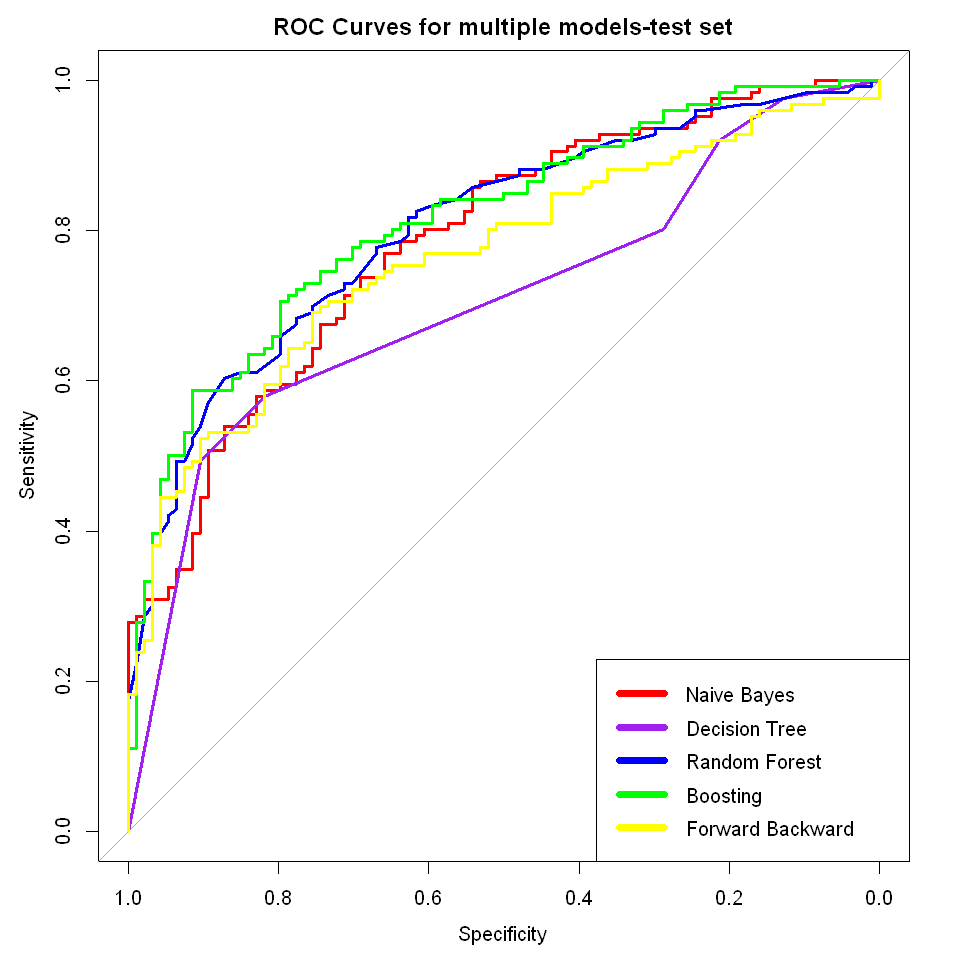

In [37]:
options(repr.plot.width = 8, repr.plot.height = 8)

plot(roc(df_test$Diagnosis, pred_prob_naive), main = "ROC Curves for multiple models-test set", col = "red", lwd = 3)
plot(roc(df_test$Diagnosis, pred_prob_tree), col = "purple", lwd = 3, add=TRUE)
plot(roc(df_test$Diagnosis, pred_prob_rf), col = "blue", lwd = 3, add=TRUE)
plot(roc(df_test$Diagnosis, pred_prob_xgb), col = "green", lwd = 3, add=TRUE)
plot(roc(df_test$Diagnosis, pred_prob_step), col = "yellow", lwd = 3, add=TRUE)

legend("bottomright", 
       legend = c("Naive Bayes", "Decision Tree", "Random Forest", "Boosting", "Forward Backward"), 
       col = c("red", "purple", "blue", "green", "yellow"), 
       lty = 1, 
       cex = 1,
       lwd = 6)

Boosting and random forest models have the best ROC curves. <br>
Naive Bayes curve is not as steep as the other ones, but it is still a reasonable roc curve. <br>
Besides accuracy, since sensitivity is more important to us, boosting model has the highest sensitivity for the test set among all other models:

<font size = 6> Final Conclusion about the most important predictors: <font>

"Length_of_Stay", "Neutrophil_Percentage", "CRP", "WBC_Count", and "Peritonitis" are the most informative variables in our dataset. <br>

Given the limited number of observations for certain values, our decision to bin the data in the Naive Bayes model to increase the number of observations within each range was reasonable. We see that all the observations who stayed longer than 7 days were diagnosed with Appendicitis.

In [98]:
table(df$Length_of_Stay)


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  19  21  28 
  4  55 275  85  47  24  23  18   8   6   1   2   1   2   1   1   1 

In [99]:
df %>% group_by(Length_of_Stay, Diagnosis) %>% summarize(count = n())

`summarise()` has grouped output by 'Length_of_Stay'. You can override using the `.groups` argument.


Length_of_Stay,Diagnosis,count
<int>,<fct>,<int>
1,0,1
1,1,3
2,0,38
2,1,17
3,0,162
3,1,113
4,0,24
4,1,61
5,0,8


In [100]:
df %>% group_by(Diagnosis) %>% summarize(mean(Neutrophil_Percentage))
df %>% group_by(Diagnosis) %>% summarize(mean(CRP))
df %>% group_by(Diagnosis) %>% summarize(mean(WBC_Count))
df %>% group_by(Diagnosis, Peritonitis) %>% summarize(count = n()) %>% mutate(perc = round(count *100/sum(count))) %>% mutate(perc = paste0(perc, "%"))

Diagnosis,mean(Neutrophil_Percentage)
<fct>,<dbl>
0,65
1,76


Diagnosis,mean(CRP)
<fct>,<dbl>
0,11
1,37


Diagnosis,mean(WBC_Count)
<fct>,<dbl>
0,10
1,14


`summarise()` has grouped output by 'Diagnosis'. You can override using the `.groups` argument.


Diagnosis,Peritonitis,count,perc
<fct>,<fct>,<int>,<chr>
0,no,213,90%
0,yes,24,10%
1,no,186,59%
1,yes,131,41%


In [101]:
df %>% group_by(Peritonitis) %>% summarize(mean(Length_of_Stay))

Peritonitis,mean(Length_of_Stay)
<fct>,<dbl>
no,3.5
yes,5.3


Peritonitis, often occurs from a burst appendix, accompanied by severe case of appendicitis. That could be the reason why not more appendicitis cases have that. <br>
Also it explains why patients who had Peritonitis, stayed in the hospital longer.

**CONCLUSION:**

Based on our models, boosting is the best model for predicting the appendicitis cases. <br>
**"Length_of_Stay"**, **"Neutrophil_Percentage"**, **"CRP"**, **"WBC_Count"**, and **"Peritonitis"** are the most informative variables in diagnosing appendicitis case. <br>
However, total length of stay is not known before diagnosis, therefore as the possible next steps we can exclude **Length_of_Stay** from the models and evaluate them again. <br>

**White blood cell counts(CRP, Neutrophil, WBC and Peritonitis)** are **good indicators of inflammation or infection**, and since the dataset is for people experiencing abdominal pain, they could be the best predictors of appendicitis cases.